**Name:** \_\_\_\_\_Huanchen Wang\_\_\_\_\_

**EID:** \_\_\_\_\_huancwang2\_\_\_\_\_

# CS5489 - Tutorial 9
## Face Detection with CNNs

In the previous tutorial, you used an MLP to detect a face in a small image patch.
In this tutorial you will train a CNN instead of an MLP.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage

Next we will load keras and tensorflow.

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout,MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import struct
K.set_image_data_format('channels_last')
import sys
print("Python:", sys.version, "Keras:", keras.__version__, "TF:", tf.__version__)

Python: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)] Keras: 2.11.0 TF: 2.11.0


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and place it in the same directory as this ipynb file.  **Do not unzip it.** Then run the following cell to load the images.

In [3]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 1
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile, as_gray=True)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

6977
944


Next we will convert the list of images into a block (array) of images for easier processing.

In [4]:
# convert list to numpy array
trainY = asarray(classes['train'])
testY  = asarray(classes['test'])

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)
testYb  = keras.utils.to_categorical(testY)

# convert list of ndarray to ndarray
trainI = asarray(imgdata['train']).reshape((6977,19,19,1))
testI  = asarray(imgdata['test']).reshape((944,19,19,1))

# cleanup memory
del imgdata

# shuffle the data (since it is in order by class)
random.seed(123)
inds1 = random.permutation(len(trainI)).tolist()
inds2 = random.permutation(len(testI)).tolist()
trainYb = trainYb[inds1]
testYb  = testYb[inds2]
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print(trainI.shape)
print(testI.shape)

(6977, 19, 19, 1)
(944, 19, 19, 1)


Each image is a 19x19x1 array of pixel values.  The last dimension is the number of channels in the image - in this case the image is grayscale, so there is only 1 channel.  Run the below code to show an example:

(19, 19)


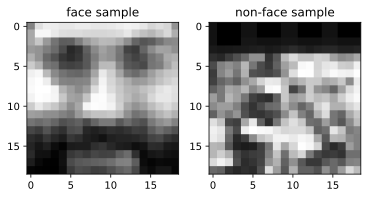

In [5]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

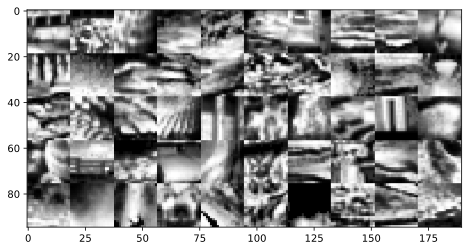

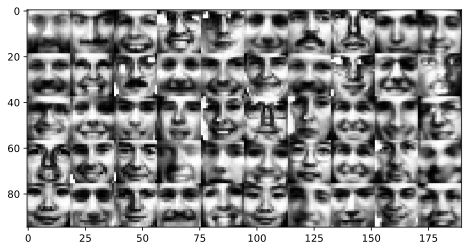

In [6]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(squeeze(X[i]))
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles.format(idx))
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,0]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,1]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

Next we will generate the training/validation set from the training data.

In [7]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(vtrainI.shape)
print(validI.shape)

(6279, 19, 19, 1)
(698, 19, 19, 1)


Here are some useful functions.

In [8]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

Now let's try a simple logistic regression classifier, trained using Keras. Since the inputs are images, we will convert the input image into a vector using the "Flatten" layer first.

Epoch 9: early stopping
test accuracy: 0.6091101694915254


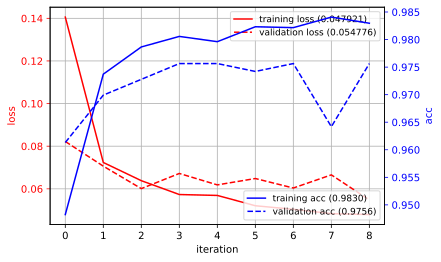

In [9]:
# initialize random seed
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI,  # specify the validation set
                 verbose=False)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## 2. Detection using CNN

Train an CNN to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, early stopping, regularization, etc. to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to add the `callbacks` so that you can monitor the training process.

In [10]:
### INSERT YOUR CODE HERE

from tensorflow.python.keras import regularizers

## First Architecture: 4 layers CNN with 1 Convolution layers

Epoch 34: early stopping


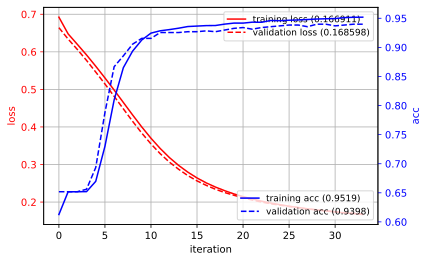

test accuracy: 0.7213983050847458
learning rate: 0.0001
regularization: 0.0001
Number of parameters: 410306
Epoch 32: early stopping


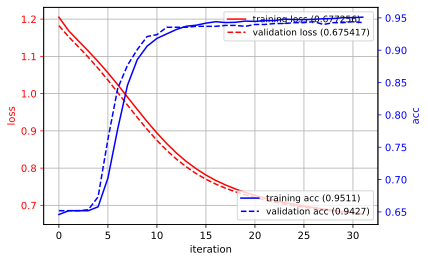

test accuracy: 0.7171610169491526
learning rate: 0.0001
regularization: 0.002154434690031882
Number of parameters: 410306
Epoch 34: early stopping


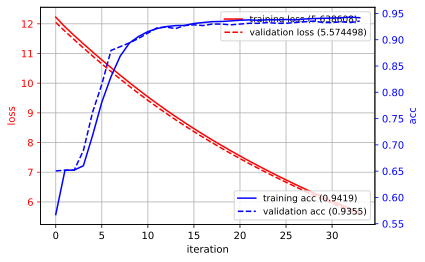

test accuracy: 0.711864406779661
learning rate: 0.0001
regularization: 0.046415888336127774
Number of parameters: 410306
Epoch 6: early stopping


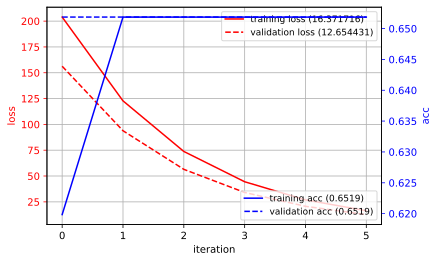

test accuracy: 0.5
learning rate: 0.0001
regularization: 1.0
Number of parameters: 410306
Epoch 32: early stopping


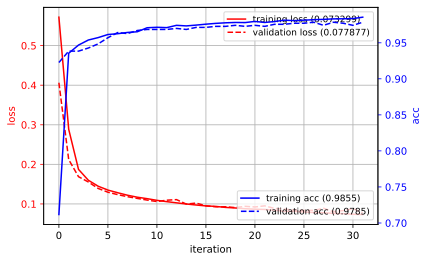

test accuracy: 0.6366525423728814
learning rate: 0.001
regularization: 0.0001
Number of parameters: 410306
Epoch 14: early stopping


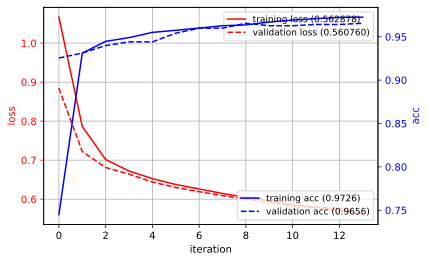

test accuracy: 0.6694915254237288
learning rate: 0.001
regularization: 0.002154434690031882
Number of parameters: 410306
Epoch 19: early stopping


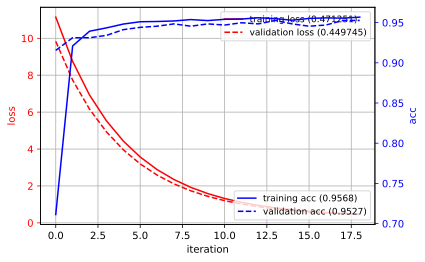

test accuracy: 0.711864406779661
learning rate: 0.001
regularization: 0.046415888336127774
Number of parameters: 410306
Epoch 6: early stopping


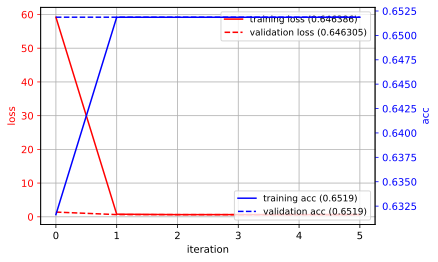

test accuracy: 0.5
learning rate: 0.001
regularization: 1.0
Number of parameters: 410306
Epoch 28: early stopping


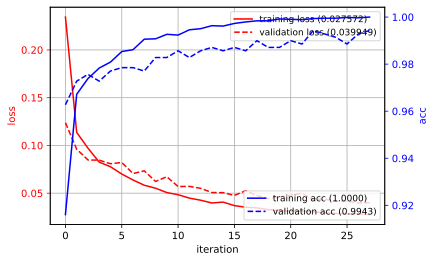

test accuracy: 0.590042372881356
learning rate: 0.01
regularization: 0.0001
Number of parameters: 410306
Epoch 31: early stopping


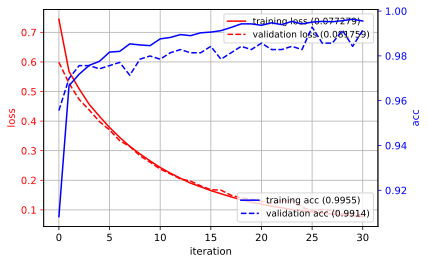

test accuracy: 0.6313559322033898
learning rate: 0.01
regularization: 0.002154434690031882
Number of parameters: 410306
Epoch 7: early stopping


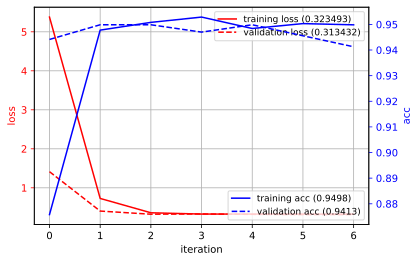

test accuracy: 0.7372881355932204
learning rate: 0.01
regularization: 0.046415888336127774
Number of parameters: 410306
Epoch 6: early stopping


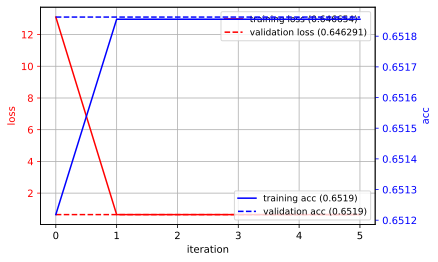

test accuracy: 0.5
learning rate: 0.01
regularization: 1.0
Number of parameters: 410306
Epoch 15: early stopping


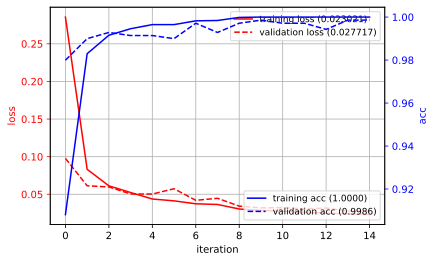

test accuracy: 0.5942796610169492
learning rate: 0.1
regularization: 0.0001
Number of parameters: 410306
Epoch 15: early stopping


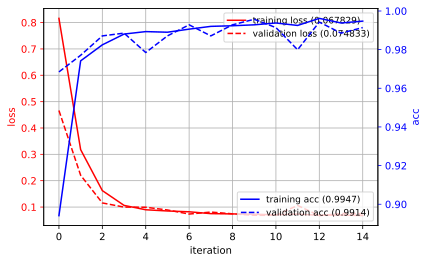

test accuracy: 0.5328389830508474
learning rate: 0.1
regularization: 0.002154434690031882
Number of parameters: 410306
Epoch 7: early stopping


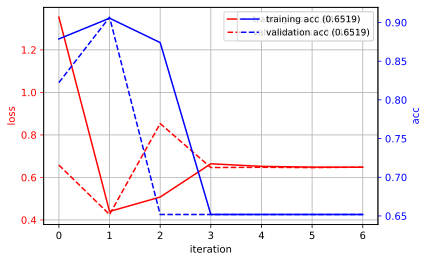

test accuracy: 0.5
learning rate: 0.1
regularization: 0.046415888336127774
Number of parameters: 410306
Epoch 6: early stopping


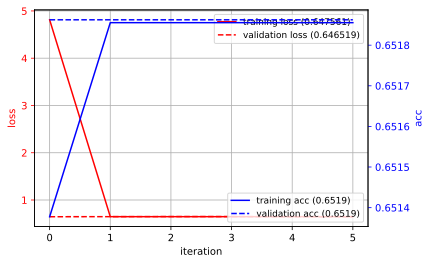

test accuracy: 0.5
learning rate: 0.1
regularization: 1.0
Number of parameters: 410306


In [11]:
lr_list = logspace(-4, -1, 4)
regularization_list = logspace(-4, 0, 4)

K.clear_session()
random.seed(4487); tf.random.set_seed(4487)
for lr in lr_list:
    for regular in regularization_list:
        nn = Sequential()
        nn.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', input_shape=(19, 19, 1), kernel_regularizer=keras.regularizers.l2(regular), padding='same'))
        nn.add(Flatten())
        nn.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(regular)))
        nn.add(Dense(2, activation='softmax', kernel_regularizer=keras.regularizers.l2(regular)))

        earlystop = keras.callbacks.EarlyStopping(
                monitor='val_accuracy',             # use validation accuracy for stopping
                min_delta=0.0001, patience=5,
                verbose=1, mode='auto')
        callbacks_list = [earlystop]
        nn.compile(loss=keras.losses.categorical_crossentropy,
                     optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True),
                        metrics=['accuracy'])
        
        history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50,
                        callbacks=callbacks_list,
                        validation_data=validsetI,  # specify the validation set
                        verbose=False)
        plot_history(history)
        plt.show()
        predY = argmax(nn.predict(testI, verbose=False), axis=-1)
        acc = metrics.accuracy_score(testY, predY)
        print("test accuracy:", acc)
        print("learning rate:", lr)
        print("regularization:", regular)
        print('Number of parameters:', nn.count_params())




## Second Architecture: 6 layers CNN with 3 Convolution layers

Epoch 6: early stopping


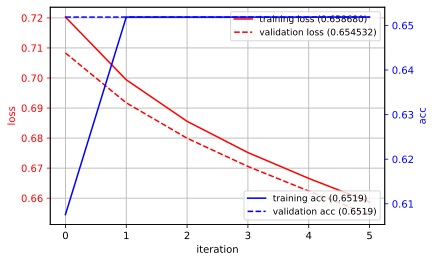

test accuracy: 0.5
learning rate: 0.0001
regularization: 0.0001
Number of parameters: 240514
Epoch 6: early stopping


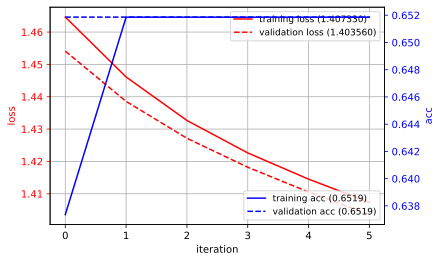

test accuracy: 0.5
learning rate: 0.0001
regularization: 0.002154434690031882
Number of parameters: 240514
Epoch 6: early stopping


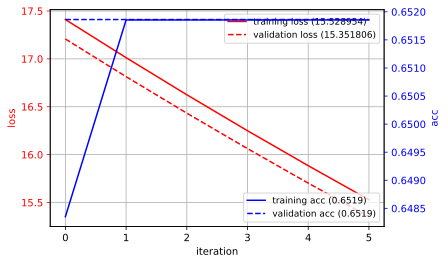

test accuracy: 0.5
learning rate: 0.0001
regularization: 0.046415888336127774
Number of parameters: 240514
Epoch 6: early stopping


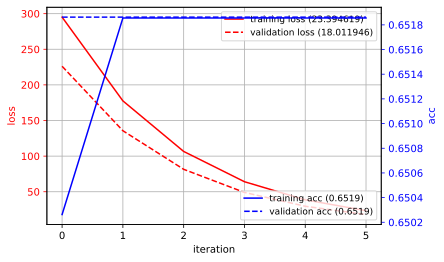

test accuracy: 0.5
learning rate: 0.0001
regularization: 1.0
Number of parameters: 240514
Epoch 21: early stopping


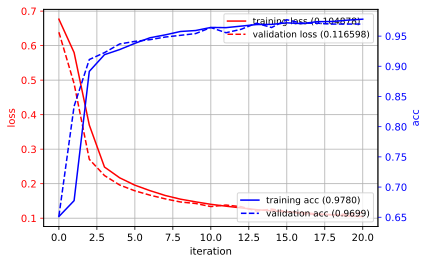

test accuracy: 0.6302966101694916
learning rate: 0.001
regularization: 0.0001
Number of parameters: 240514
Epoch 47: early stopping


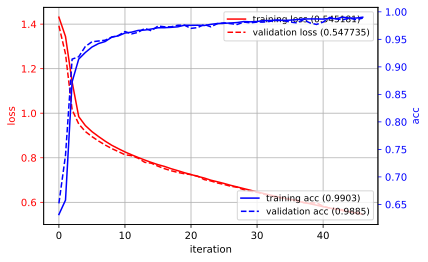

test accuracy: 0.6853813559322034
learning rate: 0.001
regularization: 0.002154434690031882
Number of parameters: 240514
Epoch 6: early stopping


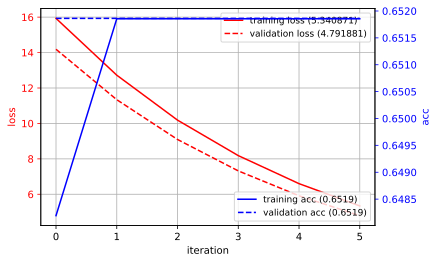

test accuracy: 0.5
learning rate: 0.001
regularization: 0.046415888336127774
Number of parameters: 240514
Epoch 6: early stopping


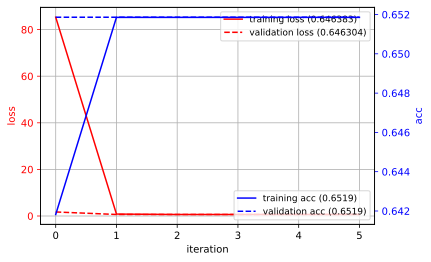

test accuracy: 0.5
learning rate: 0.001
regularization: 1.0
Number of parameters: 240514
Epoch 19: early stopping


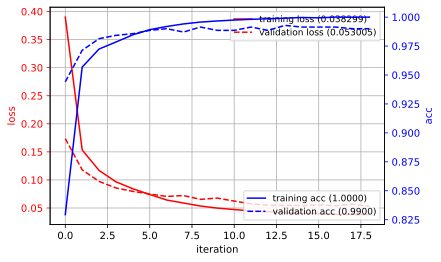

test accuracy: 0.6822033898305084
learning rate: 0.01
regularization: 0.0001
Number of parameters: 240514
Epoch 16: early stopping


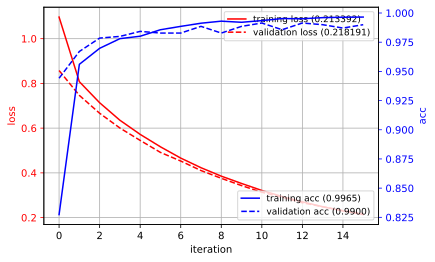

test accuracy: 0.7521186440677966
learning rate: 0.01
regularization: 0.002154434690031882
Number of parameters: 240514
Epoch 16: early stopping


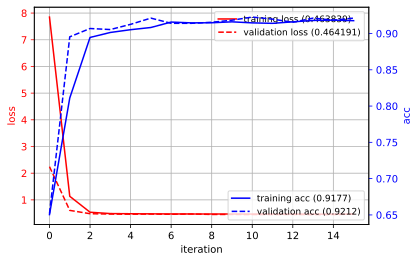

test accuracy: 0.7129237288135594
learning rate: 0.01
regularization: 0.046415888336127774
Number of parameters: 240514
Epoch 6: early stopping


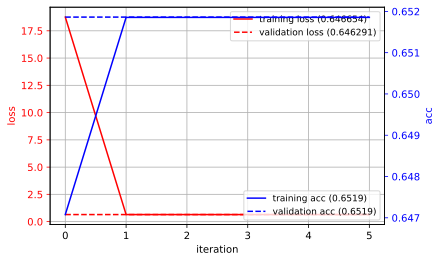

test accuracy: 0.5
learning rate: 0.01
regularization: 1.0
Number of parameters: 240514
Epoch 16: early stopping


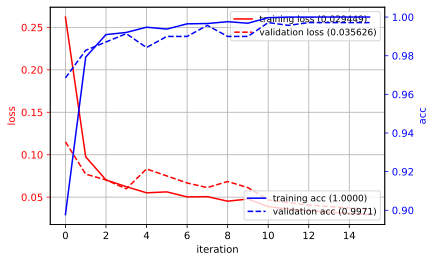

test accuracy: 0.625
learning rate: 0.1
regularization: 0.0001
Number of parameters: 240514
Epoch 11: early stopping


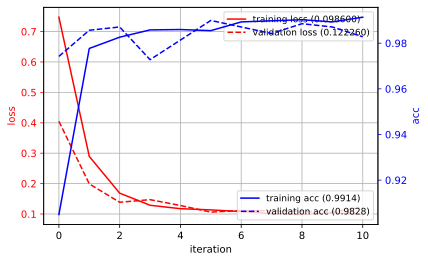

test accuracy: 0.777542372881356
learning rate: 0.1
regularization: 0.002154434690031882
Number of parameters: 240514
Epoch 6: early stopping


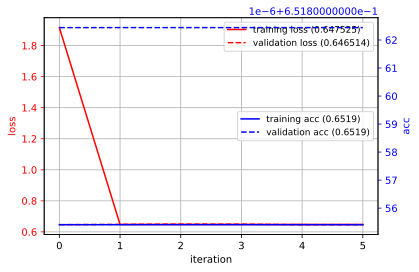

test accuracy: 0.5
learning rate: 0.1
regularization: 0.046415888336127774
Number of parameters: 240514
Epoch 6: early stopping


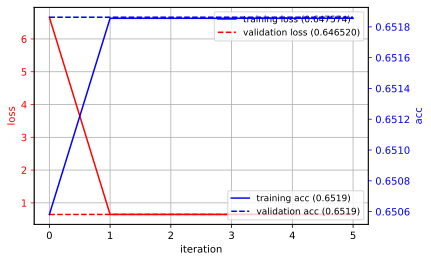

test accuracy: 0.5
learning rate: 0.1
regularization: 1.0
Number of parameters: 240514


In [12]:
lr_list = logspace(-4, -1, 4)
regularization_list = logspace(-4, 0, 4)

K.clear_session()
random.seed(4487); tf.random.set_seed(4487)
for lr in lr_list:
    for regular in regularization_list:
        nn = Sequential()
        nn.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', input_shape=(19, 19, 1), kernel_regularizer=keras.regularizers.l2(regular), padding='same'))
        nn.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu', kernel_regularizer=keras.regularizers.l2(regular), padding='same'))
        nn.add(Conv2D(128, kernel_size=(3, 3), strides=(2,2), activation='relu', kernel_regularizer=keras.regularizers.l2(regular), padding='same'))
        nn.add(Flatten())
        nn.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(regular)))
        nn.add(Dense(2, activation='softmax', kernel_regularizer=keras.regularizers.l2(regular)))

        earlystop = keras.callbacks.EarlyStopping(
                monitor='val_accuracy',             # use validation accuracy for stopping
                min_delta=0.0001, patience=5,
                verbose=1, mode='auto')
        callbacks_list = [earlystop]
        nn.compile(loss=keras.losses.categorical_crossentropy,
                     optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True),
                        metrics=['accuracy'])
        
        history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50,
                        callbacks=callbacks_list,
                        validation_data=validsetI,  # specify the validation set
                        verbose=False)
        plot_history(history)
        plt.show()
        predY = argmax(nn.predict(testI, verbose=False), axis=-1)
        acc = metrics.accuracy_score(testY, predY)
        print("test accuracy:", acc)
        print("learning rate:", lr)
        print("regularization:", regular)
        print('Number of parameters:', nn.count_params())




## Third Architecture: 7 layers CNN with Dropout and 2 Convolution layers

Epoch 7: early stopping


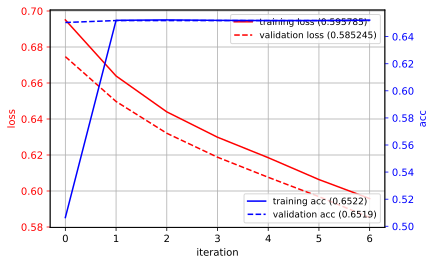

test accuracy: 0.5
learning rate: 0.0001
dropout: 0.2
Number of parameters: 224002
Epoch 6: early stopping


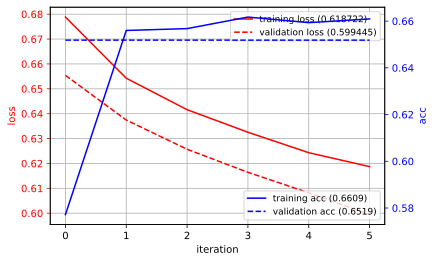

test accuracy: 0.5
learning rate: 0.0001
dropout: 0.5
Number of parameters: 224002
Epoch 6: early stopping


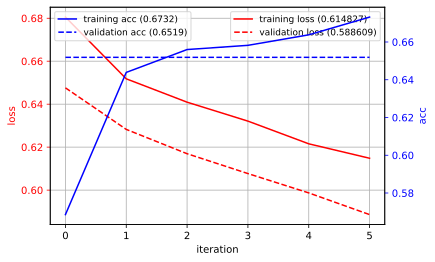

test accuracy: 0.5
learning rate: 0.0001
dropout: 0.6
Number of parameters: 224002
Epoch 6: early stopping


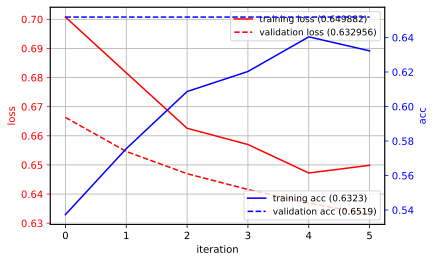

test accuracy: 0.5
learning rate: 0.0001
dropout: 0.8
Number of parameters: 224002
Epoch 30: early stopping


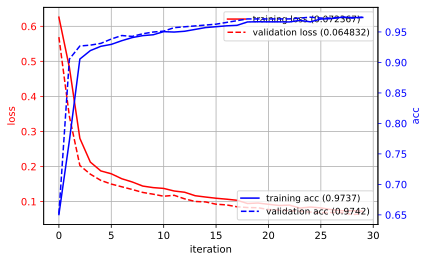

test accuracy: 0.652542372881356
learning rate: 0.001
dropout: 0.2
Number of parameters: 224002
Epoch 33: early stopping


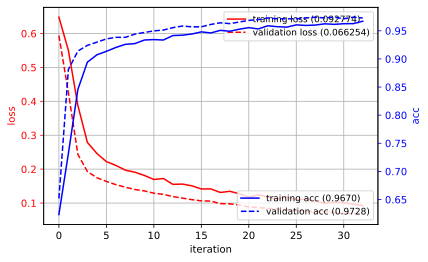

test accuracy: 0.7044491525423728
learning rate: 0.001
dropout: 0.5
Number of parameters: 224002
Epoch 36: early stopping


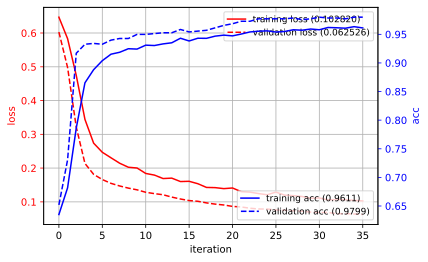

test accuracy: 0.7044491525423728
learning rate: 0.001
dropout: 0.6
Number of parameters: 224002
Epoch 38: early stopping


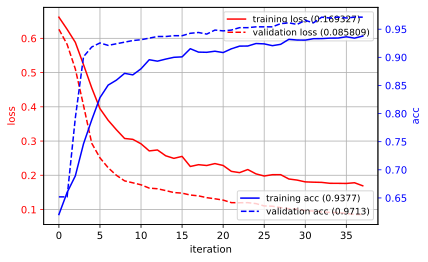

test accuracy: 0.7288135593220338
learning rate: 0.001
dropout: 0.8
Number of parameters: 224002
Epoch 14: early stopping


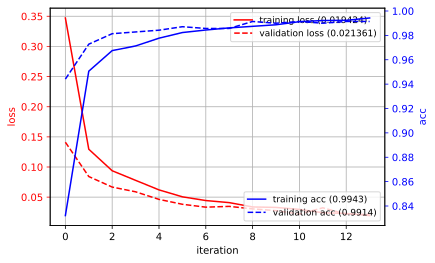

test accuracy: 0.6927966101694916
learning rate: 0.01
dropout: 0.2
Number of parameters: 224002
Epoch 25: early stopping


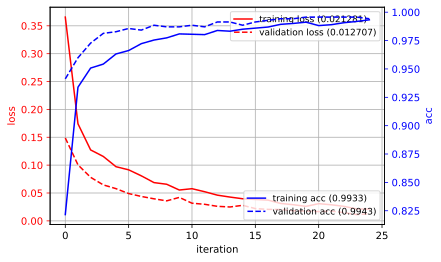

test accuracy: 0.6419491525423728
learning rate: 0.01
dropout: 0.5
Number of parameters: 224002
Epoch 15: early stopping


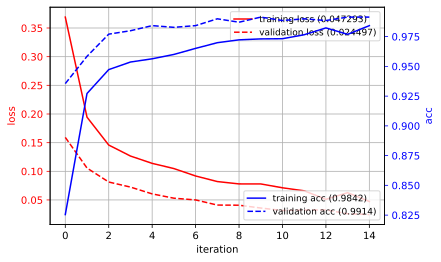

test accuracy: 0.6080508474576272
learning rate: 0.01
dropout: 0.6
Number of parameters: 224002
Epoch 15: early stopping


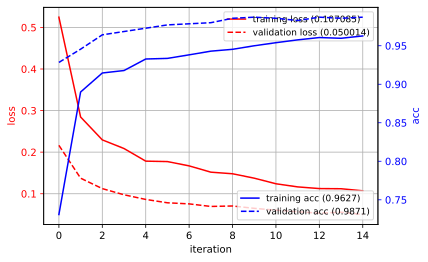

test accuracy: 0.7383474576271186
learning rate: 0.01
dropout: 0.8
Number of parameters: 224002
Epoch 14: early stopping


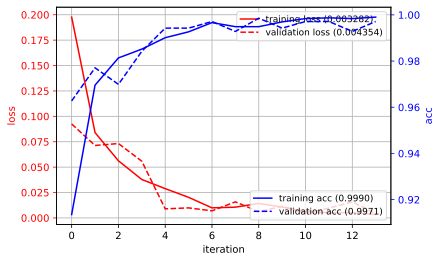

test accuracy: 0.621822033898305
learning rate: 0.1
dropout: 0.2
Number of parameters: 224002
Epoch 23: early stopping


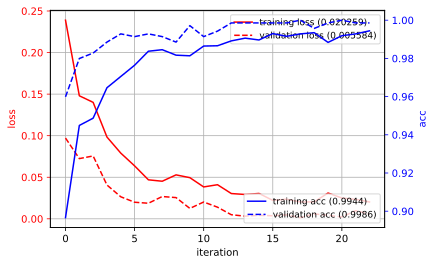

test accuracy: 0.6578389830508474
learning rate: 0.1
dropout: 0.5
Number of parameters: 224002
Epoch 19: early stopping


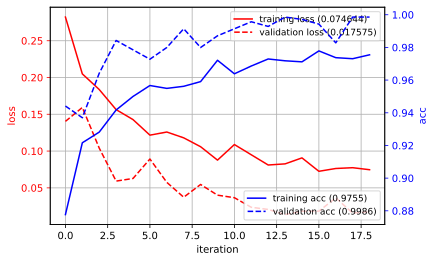

test accuracy: 0.6811440677966102
learning rate: 0.1
dropout: 0.6
Number of parameters: 224002
Epoch 8: early stopping


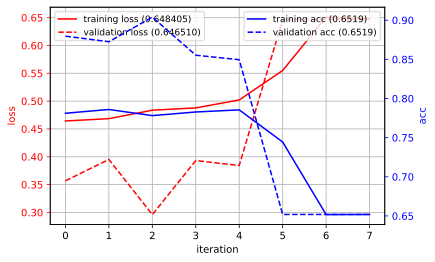

test accuracy: 0.5
learning rate: 0.1
dropout: 0.8
Number of parameters: 224002


In [14]:
lr_list = logspace(-4, -1, 4)
Dropout_list = [0.2, 0.5, 0.6, 0.8]

K.clear_session()
random.seed(4487); tf.random.set_seed(4487)
for lr in lr_list:
        for dropout in Dropout_list:
            nn = Sequential()
            nn.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', input_shape=(19, 19, 1), padding='same'))
            nn.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu',  padding='same'))
            nn.add(Dropout(dropout,seed=44))
            nn.add(Flatten())
            nn.add(Dense(128, activation='relu'))
            nn.add(Dropout(dropout,seed=45))
            nn.add(Dense(2, activation='softmax'))

            earlystop = keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',             # use validation accuracy for stopping
                    min_delta=0.0001, patience=5,
                    verbose=1, mode='auto')
            callbacks_list = [earlystop]
            nn.compile(loss=keras.losses.categorical_crossentropy,
                        optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True),
                            metrics=['accuracy'])
            
            history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50,
                            callbacks=callbacks_list,
                            validation_data=validsetI,  # specify the validation set
                            verbose=False)
            plot_history(history)
            plt.show()
            predY = argmax(nn.predict(testI, verbose=False), axis=-1)
            acc = metrics.accuracy_score(testY, predY)
            print("test accuracy:", acc)
            print("learning rate:", lr)
            print("dropout:", dropout)
            print('Number of parameters:', nn.count_params())


_How does the CNN compare to the linear and non-linear classifiers that you tried in Tutorial 4?_
- **INSERT YOUR ANSWER HERE**

### Comparing to the Tutorial 4:
- In Tutorial 4, I trained:
  -  the AdaBoost, 
  -  XGBoost, 
  -  Random Forest, 
  -  poly kernel SVM, 
  -  and rbf-kernel SVM. 
  
  The best model is the random forest classifier that achieves 0.681 accuracy for test set based on the original training dataset with cross validation.
- In this Tutorial, the CNN get the best performance when the CNN has 3 Convolutional Layers and the learning rate: 0.1, L2 regularization: 0.00215, and the Number of parameters: 240514, 
  
  Then, the accuracy can reach to **0.77** on the test dataset. It get a much improvement from the Tutorial 4's best classifier Random Forest.
- In conclusion, CNN performs better. It has higher accuracy. But, it also need some time for training, even set the early stop. 

_How does the CNN compare to the MLP classifiers that you tried in Tutorial 8?_
- **INSERT YOUR ANSWER HERE**

### Comparing to the Tutorial 8:
+ In Tutorial 8, I trained MLP and get the best performance when the learning rate: 0.01 with 2 hidden layers. And it can get 0.689 accuracy for test dataset.
+ In this Tutorial, the CNN get the best performance when the CNN has 3 Convolutional Layers and the learning rate: 0.1, L2 regularization: 0.00215, and the Number of parameters: 240514, 
  
  Then, the accuracy can reach to **0.77** on the test dataset. It get a much improvement from the Tutorial 8's best classifier MLP.
+ Besides, the number of parameters in CNN is much less than the MLP. It is 240514, and It can improve the performance from the MLP.
+ In conclusion, CNN performs better. It has higher accuracy, and less parameters. With less parameters, it can get a closed performance to the MLP, even better than MLP, which is beacuse the kernel in CNN can learn the features.

## 3. Data Augmentation

Now use data augmentation (introduced in the last tutorial) to try to improve the accuracy.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

In [9]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

Next, we define a function for adding per-pixel noise (in this case just Gaussian noise). The noise is included using the `preprocessing_function` input of the `ImageDataGenerator`.

In [10]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

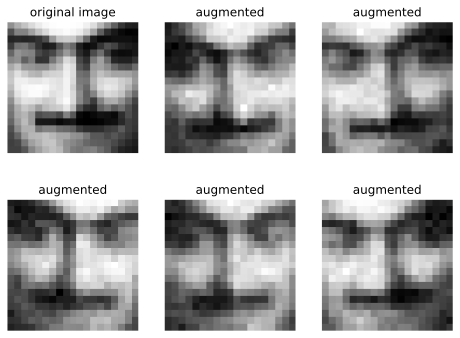

In [11]:
img = trainI[4]
imgs = [img[:,:,0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,19,19,1), [1], batch_size=1):
    imgs.append(augimg[0,:,:,0])
    cnt += 1
    if cnt > 4:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
plt.figure(figsize=(8,6))
show_imgs(imgs, nc=3, titles=titles)

The augmented images look similar to the original image, but contain small differences that the network can use to learn more about the class.

Now let's try training logistic regression with data augmentation. Instead of "fit", we now  use the "fit_generator" method, which will pass each input through the ImageDataGenerator before sending it to the MLP.  We also disable early stopping so that the training sees more augmented data.

In [18]:
# initialize random seed
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

# fit with data generator
history = nn.fit(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=50,
#           callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)


Epoch 1/50
125/125 [==============================] - 3s 17ms/step - loss: 0.2463 - accuracy: 0.8970 - val_loss: 0.1070 - val_accuracy: 0.9527
Epoch 2/50
125/125 [==============================] - 2s 15ms/step - loss: 0.1714 - accuracy: 0.9280 - val_loss: 0.1239 - val_accuracy: 0.9470
Epoch 3/50
125/125 [==============================] - 2s 15ms/step - loss: 0.1655 - accuracy: 0.9352 - val_loss: 0.1033 - val_accuracy: 0.9542
Epoch 4/50
125/125 [==============================] - 2s 16ms/step - loss: 0.1590 - accuracy: 0.9358 - val_loss: 0.1103 - val_accuracy: 0.9599
Epoch 5/50
125/125 [==============================] - 2s 16ms/step - loss: 0.1695 - accuracy: 0.9306 - val_loss: 0.0830 - val_accuracy: 0.9670
Epoch 6/50
125/125 [==============================] - 2s 16ms/step - loss: 0.1641 - accuracy: 0.9360 - val_loss: 0.1173 - val_accuracy: 0.9542
Epoch 7/50
125/125 [==============================] - 2s 15ms/step - loss: 0.1624 - accuracy: 0.9312 - val_loss: 0.1047 - val_accuracy: 0.9656

test accuracy: 0.753177966101695


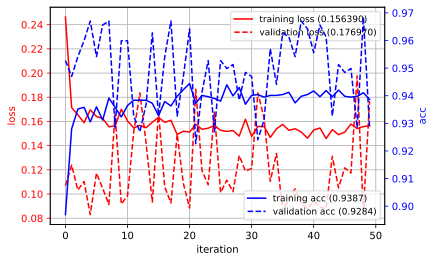

In [19]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Using data augmentation, the test accuracy improves from 0.622 to 0.692! (your numbers may be different)

Now train your best CNN from the previous section using data augmentation. 
Try different per-pixel noise levels, and different options of the ImageDataGenerator (see [here](https://keras.io/preprocessing/image/)), 
and combinations of them.  Hopefully you should be able to improve the accuracy! 

In [ ]:
### INSERT YOUR CODE HERE ###

In [51]:
## add maxpooling and batchnormalization

def model_archi(dataAug):
        nn = Sequential()

        nn.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(19, 19, 1)))
        nn.add(MaxPooling2D(pool_size=2, strides=2))
        nn.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
        nn.add(MaxPooling2D(pool_size=2, strides=2))
        nn.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
        nn.add(Flatten())
        nn.add(Dense(256, activation='relu'))
        nn.add(Dropout(0.5))
        nn.add(Dense(2, activation='softmax'))

        earlystop = keras.callbacks.EarlyStopping(
                monitor='val_accuracy',             # use validation accuracy for stopping
                min_delta=0.0001, patience=5,
                verbose=1, mode='auto')
        callbacks_list = [earlystop]
        nn.compile(loss=keras.losses.categorical_crossentropy,
                     optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
                        metrics=['accuracy'])

        history = nn.fit(
                dataAug.flow(vtrainI, vtrainYb, batch_size=100),
                steps_per_epoch=len(vtrainI)/100,
                epochs=50,
                callbacks=callbacks_list,
                validation_data=validsetI, verbose=False)


        return nn, history


Epoch 24: early stopping


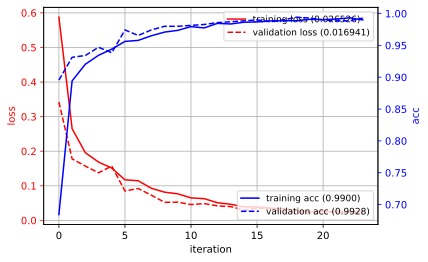

test accuracy: 0.8771186440677966


In [52]:
model, his = model_archi(datagen)
plot_history(his)
plt.show()
predY = argmax(model.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)


## Try different options of the ImageDataGenerator to find the best options

In [53]:
def select_opt(opt_name, dataaug):
    model, his = model_archi(dataaug)
    predY = argmax(model.predict(testI, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print("test accuracy with {}={}: {}".format(opt_name,getattr(dataaug, opt_name),acc))
    return model, his

In [54]:
opt_dict = {'ratation_range': [10, 30, 40], 'width_shift_range': [0.05, 0.15, 0.2], 'height_shift_range': [0.05, 0.15, 0.2], 
            'shear_range': [0.05, 0.15, 0.2], 'zoom_range': [[1-0.01, 1+0.01], [1-0.1,1+0.1], [1-0.2,1+0.2]], 'horizontal_flip': [True, False]}

for k, v in opt_dict.items():
    for i in v:
        dataaug = ImageDataGenerator(
            rotation_range=0,         # image rotation
            width_shift_range=0,     # image shifting
            height_shift_range=0,    # image shifting
            shear_range=0,           # shear transformation
            zoom_range=0,            # zooming
            horizontal_flip=False,       # horizontal flipping 
            data_format='channels_last')
        setattr(dataaug, k, i)
        model,his = select_opt(k, dataaug)


Epoch 16: early stopping
test accuracy with ratation_range=10: 0.7425847457627118
Epoch 26: early stopping
test accuracy with ratation_range=30: 0.6620762711864406
Epoch 21: early stopping
test accuracy with ratation_range=40: 0.739406779661017
Epoch 27: early stopping
test accuracy with width_shift_range=0.05: 0.7213983050847458
Epoch 31: early stopping
test accuracy with width_shift_range=0.15: 0.774364406779661
Epoch 34: early stopping
test accuracy with width_shift_range=0.2: 0.753177966101695
Epoch 14: early stopping
test accuracy with height_shift_range=0.05: 0.7309322033898306
Epoch 21: early stopping
test accuracy with height_shift_range=0.15: 0.7023305084745762
Epoch 27: early stopping
test accuracy with height_shift_range=0.2: 0.7044491525423728
Epoch 14: early stopping
test accuracy with shear_range=0.05: 0.6620762711864406
Epoch 20: early stopping
test accuracy with shear_range=0.15: 0.698093220338983
Epoch 30: early stopping
test accuracy with shear_range=0.2: 0.6906779661

### According to the result, set the best options for the ImageDataGenerator:
- rotation_range=10
- width_shift_range=0.15
- height_shift_range=0.05
- shear_range=0.15
- zoom_range=0.2
- horizontal_flip=True

## Try different noise function with different options

In [55]:
def diff_DA(func_name, para_list):
    if func_name == 'add_gauss_noise':
        def addNoise(X):
            return add_gauss_noise(X, para_list[0])
    elif func_name == 'add_corrupt_noise':
        def addNoise(X):
            return add_corrupt_noise(X, para_list[0])
    elif func_name == 'add_scale_shift':
        def addNoise(X):
            return add_scale_shift(X, para_list[0], para_list[1])
    else:
        print('Wrong function name!')

    datagen_w_noise = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.15,
        height_shift_range=0.05,
        shear_range=0.15,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=addNoise,
        data_format='channels_last')
    
    model, his = model_archi(datagen_w_noise)

    plot_history(his)
    plt.show()
    predY = argmax(model.predict(testI, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print("test accuracy:", acc)
    print('Number of parameters:', model.count_params())

    return model, his
    

### Using add_gussian_noise with sigma = 0.02

Epoch 24: early stopping


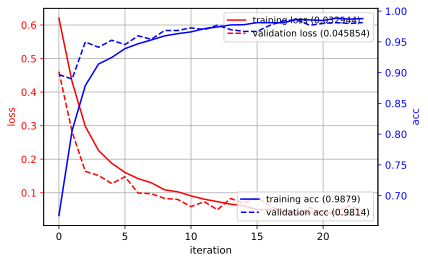

test accuracy: 0.8930084745762712
Number of parameters: 617730


In [56]:
model, his = diff_DA('add_gauss_noise', [0.02])

### Using add_gussian_noise with sigma = 0.06

Epoch 21: early stopping


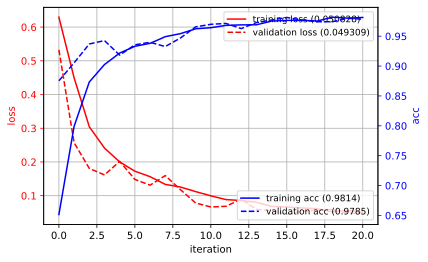

test accuracy: 0.9173728813559322
Number of parameters: 617730


In [57]:
model, history =diff_DA('add_gauss_noise', [0.06])

### Using add_gussian_noise with sigma = 0.1

Epoch 15: early stopping


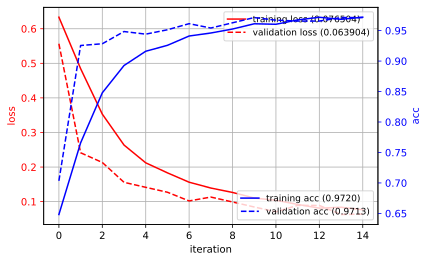

test accuracy: 0.8983050847457628
Number of parameters: 617730


In [58]:
model, history =diff_DA('add_gauss_noise', [0.1])

### Using add_corrupt_noise with p = 0.2

Epoch 22: early stopping


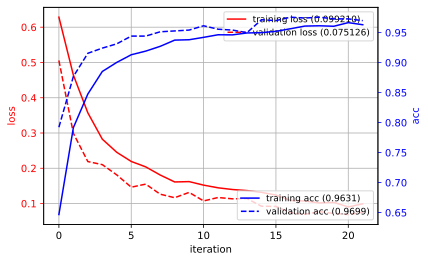

test accuracy: 0.8622881355932204
Number of parameters: 617730


In [59]:
model, history =diff_DA('add_corrupt_noise', [0.2])

### Using add_corrupt_noise with p = 0.5

Epoch 10: early stopping


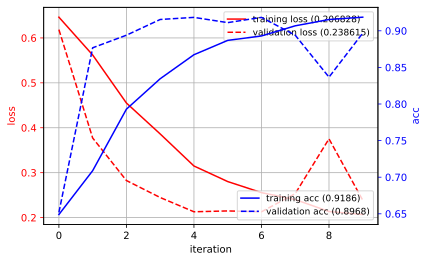

test accuracy: 0.7489406779661016
Number of parameters: 617730


In [60]:
model, history =diff_DA('add_corrupt_noise', [0.5])

### Using add_corrupt_noise with p = 0.9

Epoch 13: early stopping


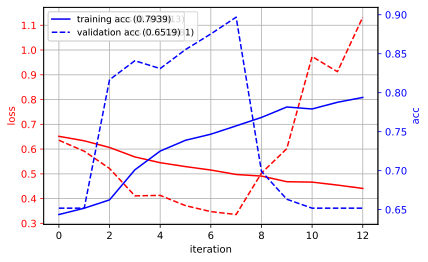

test accuracy: 0.5
Number of parameters: 617730


In [61]:
model, history =diff_DA('add_corrupt_noise', [0.9])

### Using add_scale_shift with scale=0.1, shift=0.1

Epoch 31: early stopping


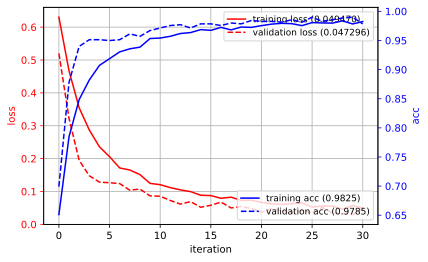

test accuracy: 0.913135593220339
Number of parameters: 617730


In [62]:
model, history = diff_DA('add_scale_shift', [0.1, 0.1])

### Using add_scale_shift with scale=0.5, shift=0.5

Epoch 7: early stopping


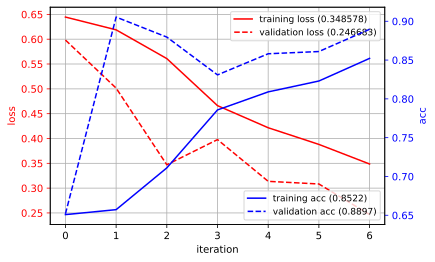

test accuracy: 0.8305084745762712
Number of parameters: 617730


In [63]:
model, history = diff_DA('add_scale_shift', [0.5, 0.5])

### Using add_scale_shift with scale=0.8, shift=0.2

Epoch 25: early stopping


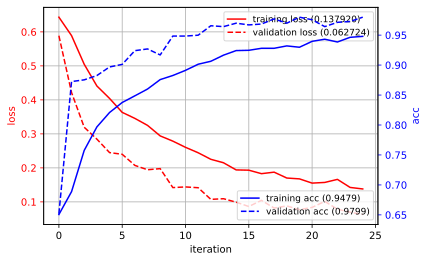

test accuracy: 0.8686440677966102
Number of parameters: 617730


In [64]:
model, history = diff_DA('add_scale_shift', [0.8, 0.2])

_How does CNN with data augmentation compare with your work in Tutorial 8?_ 
- **INSERT YOUR ANSWER HERE**

### According to the results:
+ The the data augmentation with add **guassian noise** can get higher improvement level. 
  
  I try the 3 group parameters including: $\sigma=0.02$, $p=0.06$, and $p=0.1$. The best one is $\sigma=0.06$. It can get the best accuracy **0.917** on test dataset, which is also the highest accuracy in this tutorial.
+ Since data augmentation can increase the amount and variety of training data for the model. It involves creating new training examples by applying various transformations to the existing data. Then it will help improve the accuracy and robustness of the model by making it more resilient to variations.
  
  Based on the result, I think do the guassian for image can make each image more different from each other than the other noise function. Thus, add or sub a density on some pixels, which can impact more to make the image more diversity in the add_guassian_noise function.
  
  Thus, the CNN can learn more from the data and get better performance and improve the model's robustness in test dataset.

+ In Tutorial 8, I also got the best performance when using the add_guassain noise function but with $\sigma=01$. It can get 0.8485 accuracy on test dataset.

  In this Tutorial, **the scale and shift, and corruption data augmentation does not work better than the guassian data augmentation.** 
  
  In my opinion, since the Convolutional Layer with kernel can improve the robustness when the pixel location is changed. Thus, the scale and shift, and corruption data augmentation does not work better.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [65]:
fname = "nasa-small.png"

(210, 480)


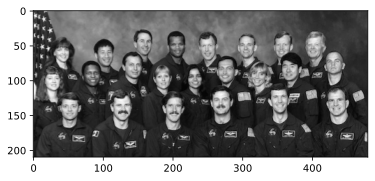

In [66]:
# load image
testimg = skimage.io.imread(fname, as_gray=True)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [67]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI = patches2

(5568, 19, 19, 1)


Now predict using your classifier.  The extracted images are in `newI`.

In [68]:
prednewY = argmax(model.predict(newI), axis=-1)

174/174 [==============================] - 1s 6ms/step


Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

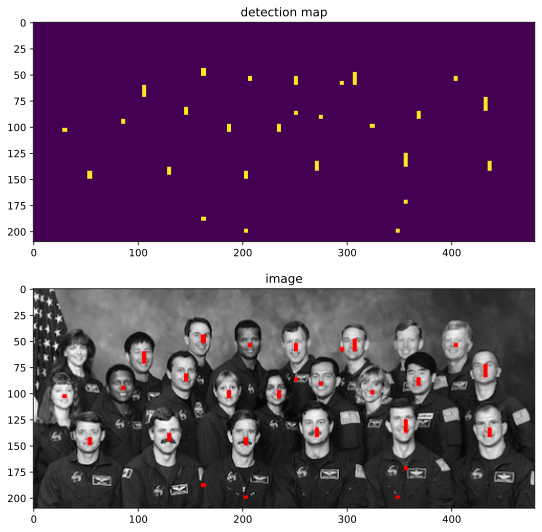

In [69]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do compared to the last version?_
- **INSERT YOUR ANSWER HERE**

### Comparing to the last version:
+ In the last version in Tutorial 8:
  + It focus more face region to detect face, including the hear, nose, beard, neck and two sides of head.
  
  + However, it gets even higher FPR that detect less no-human facial pixel as the facial pixel than the Tutorial 4, especially do not detect the wall as the facial pixel.
  
  + Besides, it still classfiy some medals and badges as the facial pixel, but this situation is less than the last version.
+ In this version:
  + It mainly focus on the nose and beard for the face detection.
  + It gets much lower FPR that detect less no-human facial pixel as the facial pixel than the Tutorial 8
    
    Espeacially, it does not pay more attention on the neck and two sides of head, which is not apparent than the nose and beard during the face detection.
  + It classfiy much less medals and badges as the facial pixel than the last version in Tutorail 8. But it still classfiy a little medals, badges and star on the flag as the facial pixel.

You can try it on your own images.  The faces should all be around 19x19 pixels though. We only used 1/8 of the training data. Try using more data to train it!

(270, 480)
(7308, 19, 19, 1)


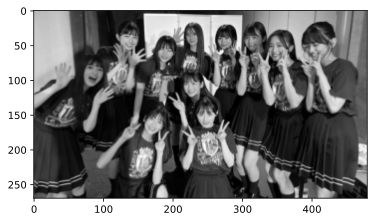

In [70]:
# predict my own image:
fname = "./5th.png"

# load image
testimg = skimage.io.imread(fname, as_gray=True)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI_my = patches2


In [71]:
predY_my = argmax(model.predict(newI_my, verbose=False), axis=-1)

(-0.5, 479.5, 269.5, -0.5)

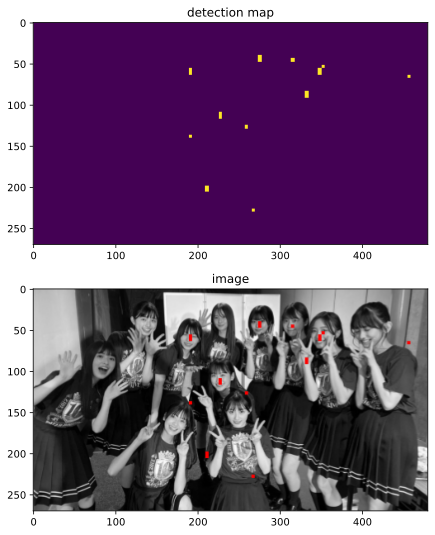

In [72]:
imgY_my = predY_my.reshape(psize[0], psize[1])

imgY2_my = ndimage.interpolation.zoom(imgY_my, step, output=None, order=0)
imgY2_my = vstack((zeros((9, imgY2_my.shape[1])), imgY2_my))
imgY2_my = hstack((zeros((imgY2_my.shape[0],9)), imgY2_my))
if (imgY2_my.shape[0] != testimg.shape[0]):
    imgY2_my = vstack((imgY2_my, zeros((testimg.shape[0]-imgY2_my.shape[0], imgY2_my.shape[1]))))
if (imgY2_my.shape[1] != testimg.shape[1]):
    imgY2_my = hstack((imgY2_my, zeros((imgY2_my.shape[0],testimg.shape[1]-imgY2_my.shape[1]))))

nimgY2_my = 1-imgY2_my
tmp = nimgY2_my*testimg
detimg_my = dstack((imgY2_my+tmp, tmp, tmp))

plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2_my, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg_my)
plt.title('image')
plt.axis('image')

